# Import libraries & Read CSV Files

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

import numpy as np
import re
import spacy

import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

import nltk
from nltk import FreqDist
from nltk.corpus import stopwords

from datetime import datetime
from pprint import pprint

import pickle 
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Air B&B Reviews from march to nov 
reviews_11 = pd.read_csv('./Data/reviews_11.csv')
reviews_10 = pd.read_csv('./Data/reviews_10.csv')
reviews_09 = pd.read_csv('./Data/reviews_09.csv')
reviews_08 = pd.read_csv('./Data/reviews_08.csv')
reviews_07 = pd.read_csv('./Data/reviews_07.csv')
reviews_06 = pd.read_csv('./Data/reviews_06.csv')
reviews_05 = pd.read_csv('./Data/reviews_05.csv')
reviews_04 = pd.read_csv('./Data/reviews_04.csv')
reviews_03 = pd.read_csv('./Data/reviews_03.csv')

In [3]:
# Merging all files into 1 
reviews = pd.concat([reviews_03,reviews_04,reviews_05,reviews_06,reviews_07,reviews_08,reviews_09,reviews_10,reviews_11], axis=0)

In [4]:
reviews

listing_id         id        date  reviewer_id reviewer_name  \
0       49091       8243238    2013-10-21  8557223      Jared          
1       50646       11909864   2014-04-18  1356099      James          
2       50646       13823948   2014-06-05  15222393     Welli          
3       50646       15117222   2014-07-02  5543172      Cyril          
4       50646       15426462   2014-07-08  817532       Jake           
...       ...            ...          ...     ...        ...           
107317  40138508    566024301  2019-11-18  217531255    Nicole         
107318  40179744    568844765  2019-11-24  311670601    一横妹            
107319  40226189    566900233  2019-11-21  164625805    J              
107320  40293519    569255764  2019-11-25  121439293    Keith          
107321  40293519    569256607  2019-11-25  232854466    Annie          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     comments  
0       Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [5]:
reviews.shape

(915641, 6)

In [6]:
reviews.dtypes

listing_id       int64 
id               int64 
date             object
reviewer_id      int64 
reviewer_name    object
comments         object
dtype: object

In [7]:
reviews.to_csv('./data/reviews_compiled.csv', index=False)

## Data Cleaning

#### Dropping columns that are not in use, Interested only in the comments, listing_id and date reviewed 

In [8]:
reviews = reviews.drop(columns=['reviewer_id','id'])

#### Changing date format

In [9]:
reviews['date'] = pd.to_datetime(reviews.date)

#### Retaining only english words

In [10]:
reviews.loc[107225]

listing_id       39369817           
date             2019-10-22 00:00:00
reviewer_name    能                  
comments         非常好的房间,非常好的房东~     
Name: 107225, dtype: object

In [11]:
reviews['comments'] = reviews['comments'].apply(lambda x: re.sub(r'[^a-zA-Z0-9$@$!%*?&#^-_.+]+$', 'non-english', str(x)))
reviews['reviewer_name'] = reviews['reviewer_name'].apply(lambda x: re.sub(r'[^a-zA-Z0-9$@$!%*?&#^-_.+]+$','non-english', str(x)))

In [12]:
reviews.loc[107225]

listing_id       39369817           
date             2019-10-22 00:00:00
reviewer_name    non-english        
comments         non-english        
Name: 107225, dtype: object

In [13]:
reviews["comments"]

0         Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [14]:
# removing the ' non-english ' rows 
reviews = reviews[(reviews['comments']!='non-english') & (reviews['reviewer_name']!='non-english')]

In [15]:
reviews.shape

(826365, 4)

#### Checking for nulls 

In [16]:
reviews.isnull().sum()

listing_id       0
date             0
reviewer_name    0
comments         0
dtype: int64

#### Checking for duplicates

In [17]:
reviews[reviews.duplicated(['comments'])].shape

(700728, 4)

Overlapping/same reviews are duplicated from consecutive overlapping months 

In [18]:
reviews.drop_duplicates(subset=['comments']).shape

(125637, 4)

In [19]:
reviews.drop_duplicates(subset=['comments'], inplace = True)

In [20]:
reviews.drop_duplicates(subset=['comments'], inplace = True)

In [21]:
reviews.shape

(125637, 4)

#### Removing automated messages

In [22]:
reviews[reviews.comments.str.contains("This is an automated posting")].head()

listing_id       date reviewer_name  \
25   56334      2013-02-14  Allen&Lisa     
50   71609      2019-01-06  Yasukawa       
167  241503     2013-05-01  Sonal          
169  241503     2013-05-21  Milka          
322  241508     2012-06-14  Yee Shan       

                                                                                      comments  
25   The reservation was canceled 38 days before arrival. This is an automated posting.         
50   The host canceled this reservation 123 days before arrival. This is an automated posting.  
167  The reservation was canceled 11 days before arrival. This is an automated posting.         
169  The reservation was canceled 9 days before arrival. This is an automated posting.          
322  The reservation was canceled 57 days before arrival. This is an automated posting.

In [23]:
reviews[reviews.comments.str.contains("This is an automated posting")].shape

(185, 4)

In [24]:
reviews[~reviews.comments.str.contains("This is an automated posting")].shape

(125452, 4)

In [25]:
reviews = reviews[~reviews.comments.str.contains("This is an automated posting")]

In [26]:
reviews.shape

(125452, 4)

#### Checking for unique values

In [27]:
reviews.nunique()

listing_id       6993  
date             2555  
reviewer_name    37129 
comments         125452
dtype: int64

In [28]:
reviews.reset_index(drop=True)

listing_id       date reviewer_name  \
0       49091      2013-10-21  Jared          
1       50646      2014-04-18  James          
2       50646      2014-06-05  Welli          
3       50646      2014-07-02  Cyril          
4       50646      2014-07-08  Jake           
...       ...             ...   ...           
125447  40012885   2019-11-23  Mia            
125448  40014434   2019-11-23  Shunsuke       
125449  40129228   2019-11-24  Savas          
125450  40138508   2019-11-18  Nicole         
125451  40226189   2019-11-21  J              

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     comments  
0       Fran was absolutely gracious and welcoming. Made my stay a great experience. Would definitely recommend this cozy and peaceful place to anyone.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

#### Exploring number of reviews within the same listing_id

In [29]:
reviews['listing_id'].value_counts()

2129215     294
2357514     292
10848771    289
4108082     282
21509015    277
           ... 
35182385    1  
28620313    1  
30969374    1  
39679521    1  
29973157    1  
Name: listing_id, Length: 6993, dtype: int64

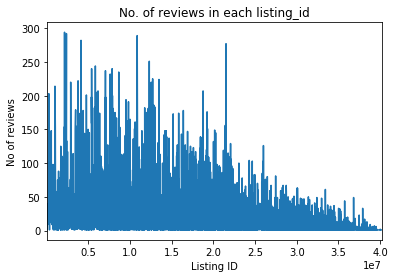

In [30]:
plt.figure(figsize=(6,4))

reviews.groupby('listing_id')['listing_id'].count().plot()

plt.ylabel('No of reviews')
plt.xlabel('Listing ID')
plt.title('No. of reviews in each listing_id')
plt.show()

In [31]:
reviews['listing_id'].value_counts().mean()

17.93965393965394

#### Making function to plot top 20 words

In [32]:
# function to plot most frequent terms
def freq_words(x, terms = 20):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data=d, x= "count", y = "word", color='red').set_title('Top 20 Words')
    plt.show()

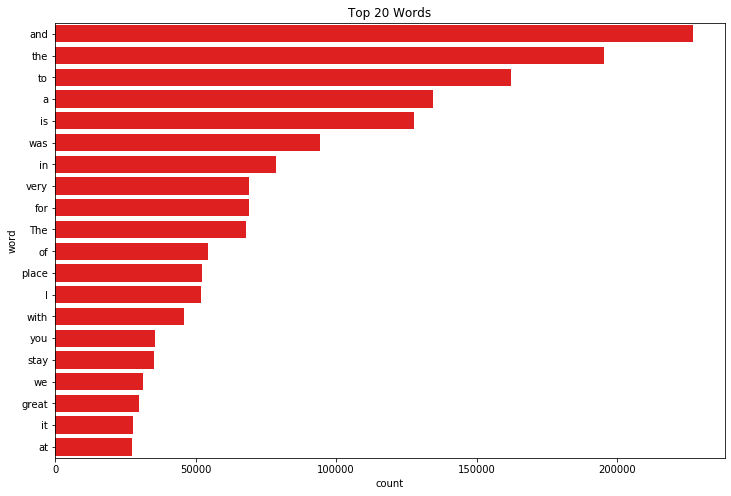

In [33]:
freq_words(reviews['comments'])

## Pre-processing of texts

In [34]:
# Remove punctuation
reviews['comments'] = reviews['comments'].map(lambda x: re.sub('[,.!?]', '', x))
# Convert the titles to lowercase
reviews['comments'] = reviews['comments'].map(lambda x: x.lower())
# Print out the first rows of papers
reviews['comments'].head(1)

0    fran was absolutely gracious and welcoming made my stay a great experience would definitely recommend this cozy and peaceful place to anyone
Name: comments, dtype: object

#### Tokenizing

In [35]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data = reviews.comments.values.tolist()
data_words = list(sent_to_words(data))

In [36]:
print(data_words[900])

['place', 'is', 'accessible', 'to', 'all', 'restaurant', 'and', 'mall', 'very', 'convenient', 'and', 'relaxing', 'thanks', 'to', 'joyce', 'and', 'mylene', 'for', 'being', 'nice']


In [37]:
# Unpacking the list of list in data_word for visualization
data_word_list = [item for sublist in data_words for item in sublist]

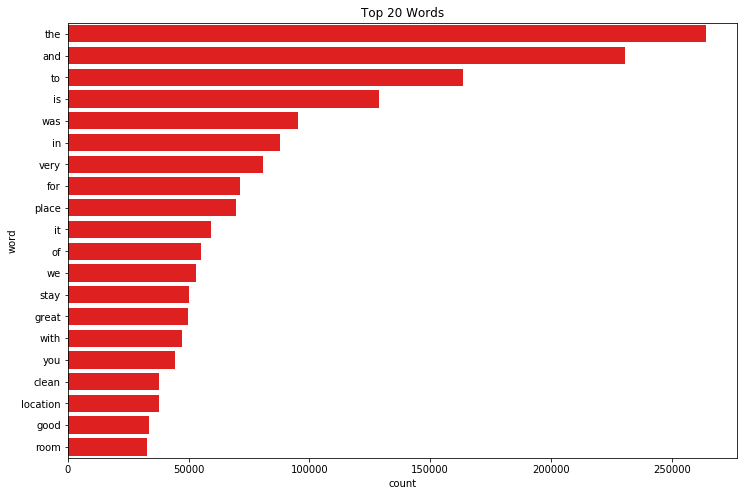

In [38]:
freq_words(data_word_list)

#### Managing Bi- & Tri-grams

In [39]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Making function to deal with stopwords, and lemmatization

In [40]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [41]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only nouns
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

In [42]:
len(data_lemmatized)

125452

In [43]:
data_lemmatized[900]

['restaurant', 'mall', 'thank']

In [44]:
print(data_words[900])

['place', 'is', 'accessible', 'to', 'all', 'restaurant', 'and', 'mall', 'very', 'convenient', 'and', 'relaxing', 'thanks', 'to', 'joyce', 'and', 'mylene', 'for', 'being', 'nice']


In [45]:
# Unpacking the list of list in data_lemmatized for visualization
data_lemmatized_list = [item for sublist in data_lemmatized for item in sublist]

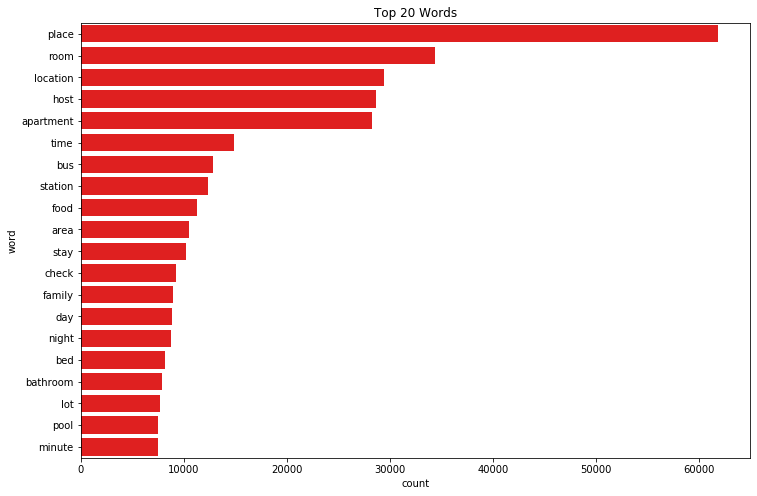

In [46]:
freq_words(data_lemmatized_list)

-----------------

## LDA Modelling Preparations

#### Preparing Dictionary and Corpus for LDA

In [47]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
# number of unique words in the dictionary
len(id2word)

18981

In [49]:
# number of words in the whole corpus 
len(corpus)

125452

#### Representation of words in corpus: (word id, frequency in document)

In [50]:
data_lemmatized[900]

['restaurant', 'mall', 'thank']

In [51]:
corpus[900]

[(32, 1), (165, 1), (656, 1)]

## Building LDA Models
#### LDA 'imagines' a pre-determined no. of topics. (Unsupervised Learning)
- Each topic represents a set of words. The goal of LDA is to map all the documents to the topics in a way, such that the words in each document are mostly captured by those imaginary topics. 

#### Latent Dirichlet Allocation Model's Assumption:
- Documents are produced from a mixture of topics
- Topics then generate words based on their probability distribution

Given a Dataset of documents, LDA backtracks and tries to figure out what topic would those documents belongin the first place

#### In-depth mechanics of LDA
For every topic, two probabilities p1 and p2 are calculated. 
- p1 – p(topic t / document d) = the proportion of words in document d that are currently assigned to topic t. 
- p2 – p(word w / topic t) = the proportion of assignments to topic t over all documents that come from this word w.

The current topic – word assignment is updated with a new topic with the probability, product of p1 and p2 . 
- In this step, the model assumes that all the existing word – topic assignments except the current word are correct.
- This is essentially the probability that topic t generated word w, so it makes sense to adjust the current word’s topic with new probability.

After a number of iterations, a steady state is achieved where the document topic and topic term distributions are fairly good. This is the convergence point of LDA.

In [52]:
LDA = gensim.models.ldamodel.LdaModel

#### Build LDA model for 3-10 number of topics, and compute coherence score

In [53]:
# 13 topics in LDA
lda_model13 = LDA(corpus=corpus, id2word=id2word, num_topics=13, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda13 = CoherenceModel(model=lda_model13, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda13 = coherence_model_lda13.get_coherence()
print('Coherence Score for 13 Topics: ', coherence_lda13)

Coherence Score for 13 Topics:  0.5225283244473861


In [54]:
# 12 topics in LDA
lda_model12 = LDA(corpus=corpus, id2word=id2word, num_topics=12, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda12 = CoherenceModel(model=lda_model12, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda12 = coherence_model_lda12.get_coherence()
print('Coherence Score for 12 Topics: ', coherence_lda12)

Coherence Score for 12 Topics:  0.5429245452636922


In [55]:
# 11 topics in LDA
lda_model11 = LDA(corpus=corpus, id2word=id2word, num_topics=11, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda11 = CoherenceModel(model=lda_model11, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda11 = coherence_model_lda11.get_coherence()
print('Coherence Score for 11 Topics: ', coherence_lda11)

Coherence Score for 11 Topics:  0.5411137086084893


In [56]:
# 10 topics in LDA
lda_model10 = LDA(corpus=corpus, id2word=id2word, num_topics=10, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda10 = CoherenceModel(model=lda_model10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda10 = coherence_model_lda10.get_coherence()
print('Coherence Score for 10 Topics: ', coherence_lda10)

Coherence Score for 10 Topics:  0.541086142422259


In [57]:
# 9 topics in LDA
lda_model9 = LDA(corpus=corpus, id2word=id2word, num_topics=9, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda9 = CoherenceModel(model=lda_model9, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda9 = coherence_model_lda9.get_coherence()
print('Coherence Score for 9 Topics: ', coherence_lda9)

Coherence Score for 9 Topics:  0.5382210543237852


In [58]:
# 8 topics in LDA
lda_model8 = LDA(corpus=corpus, id2word=id2word, num_topics=8, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda8 = CoherenceModel(model=lda_model8, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda8 = coherence_model_lda8.get_coherence()
print('Coherence Score for 8 Topics: ', coherence_lda8)

Coherence Score for 8 Topics:  0.541039151718009


In [59]:
# 7 topics in LDA
lda_model7 = LDA(corpus=corpus, id2word=id2word, num_topics=7, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda7 = CoherenceModel(model=lda_model7, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda7 = coherence_model_lda7.get_coherence()
print('Coherence Score for 7 Topics: ', coherence_lda7)

Coherence Score for 7 Topics:  0.5283016721123358


In [60]:
# 6 topics in LDA
lda_model6 = LDA(corpus=corpus, id2word=id2word, num_topics=6, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda6 = CoherenceModel(model=lda_model6, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda6 = coherence_model_lda6.get_coherence()
print('Coherence Score for 6 Topics: ', coherence_lda6)

Coherence Score for 6 Topics:  0.5515338716227522


In [61]:
# 5 topics in LDA
lda_model5 = LDA(corpus=corpus, id2word=id2word, num_topics=5, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda5 = CoherenceModel(model=lda_model5, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda5 = coherence_model_lda5.get_coherence()
print('Coherence Score for 5 Topics: ', coherence_lda5)

Coherence Score for 5 Topics:  0.5656705554957614


In [62]:
# 4 topics in LDA
lda_model4 = LDA(corpus=corpus, id2word=id2word, num_topics=4, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda4 = CoherenceModel(model=lda_model4, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda4 = coherence_model_lda4.get_coherence()
print('Coherence Score for 4 Topics: ', coherence_lda4)

Coherence Score for 4 Topics:  0.5550595852973751


In [63]:
# 3 topics in LDA
lda_model3 = LDA(corpus=corpus, id2word=id2word, num_topics=3, random_state=100,
                chunksize=200, passes=20, per_word_topics=True)

coherence_model_lda3 = CoherenceModel(model=lda_model3, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda3 = coherence_model_lda3.get_coherence()
print('Coherence Score for 3 Topics: ', coherence_lda3)

Coherence Score for 3 Topics:  0.5398196172831882


### Model Evaluation & Selection

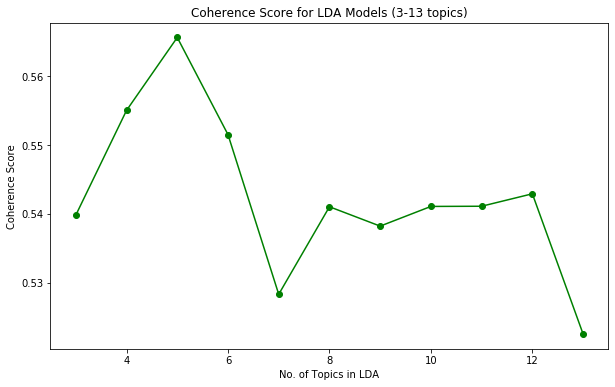

In [64]:
# Defining coordinates to be plotted on X and Y axes respectively
x = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
y = [coherence_lda3, coherence_lda4, coherence_lda5, coherence_lda6, 
     coherence_lda7, coherence_lda8, coherence_lda9, coherence_lda10,
     coherence_lda11, coherence_lda12, coherence_lda13]

# Plot lists 'x' and 'y'
plt.figure(figsize=(10,6))
plt.plot(x, y, 'go-')

# Plot axes labels and show the plot
plt.xlabel('No. of Topics in LDA')
plt.ylabel('Coherence Score')
plt.title('Coherence Score for LDA Models (3-13 topics)')
plt.show()

### Visualizing the LDA(s) for selection of model based on Top 3 coherence score

In [65]:
# 5 Topics
pyLDAvis.enable_notebook()

LDAvis_prepared5 = pyLDAvis.gensim.prepare(lda_model5, corpus, id2word)
LDAvis_prepared5

/Users/shaunkse/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.309443 -0.072789  1       1        21.730062
4     -0.187977  0.053763  2       1        21.074228
1     -0.174898 -0.320929  3       1        20.564083
0     -0.151043  0.261623  4       1        20.241037
3      0.204475  0.078331  5       1        16.390594, topic_info=    Category          Freq        Term         Total  loglift  logprob
1    Default  63777.000000  place       63777.000000  30.0000  30.0000
10   Default  30730.000000  room        30730.000000  29.0000  29.0000
44   Default  25328.000000  apartment   25328.000000  28.0000  28.0000
3    Default  29482.000000  host        29482.000000  27.0000  27.0000
7    Default  34535.000000  location    34535.000000  26.0000  26.0000
..       ...           ...       ...             ...      ...      ...
0    Topic5   1741.383911   experience  5456.788086   0.6663  -4.4824 
149  Topic5   1825.210571   bed         8545.291992   0.2648  -4.4353 
210  Topic5   1302.595093   floor       3132.151123   0.9311  -4.7727 
159  Topic5   1671.762939   night       9093.036133   0.1148  -4.5232 
117  Topic5   1428.846436   space       7309.275391   0.1762  -4.6802 

[249 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
15    4      0.999771  access       
173   3      0.999519  accommodation
303   4      0.998708  adult        
51    3      0.757093  airport      
51    5      0.242696  airport      
...  ..           ...      ...      
280   4      0.999551  week         
949   3      0.998364  wifi         
829   1      0.999493  window       
226   1      0.824904  work         
226   2      0.174817  work         

[252 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

Inferring Topic Names
1- Apartment/Room amenities
2- Value
3- Assessibilty/Transportation
4- Facilities
5- Hospitality/Experience

In [66]:
# 4 Topics
pyLDAvis.enable_notebook()

LDAvis_prepared4 = pyLDAvis.gensim.prepare(lda_model4, corpus, id2word)
LDAvis_prepared4

/Users/shaunkse/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.143513 -0.020809  1       1        30.175341
2      0.378007 -0.084233  2       1        27.556107
3     -0.186405 -0.245133  3       1        21.252739
0     -0.048090  0.350174  4       1        21.015814, topic_info=    Category          Freq       Term         Total  loglift  logprob
1    Default  65942.000000  place      65942.000000  30.0000  30.0000
10   Default  30202.000000  room       30202.000000  29.0000  29.0000
44   Default  24363.000000  apartment  24363.000000  28.0000  28.0000
3    Default  29700.000000  host       29700.000000  27.0000  27.0000
45   Default  11146.000000  area       11146.000000  26.0000  26.0000
..       ...           ...   ...                ...      ...      ...
15   Topic4   2818.295898   access     4210.048828   1.1586  -4.2495 
7    Topic4   6670.281250   location   34773.687500 -0.0913  -3.3879 
18   Topic4   1572.227417   bit        5915.645020   0.2348  -4.8331 
403  Topic4   1431.578003   min        2635.221680   0.9497  -4.9268 
35   Topic4   1469.925781   city       4843.028320   0.3676  -4.9004 

[207 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
15    1      0.330400  access       
15    4      0.669351  access       
173   1      0.252736  accommodation
173   2      0.119935  accommodation
173   3      0.627066  accommodation
...  ..           ...            ...
208   2      0.999673  water        
280   4      0.999318  week         
829   2      0.999735  window       
226   2      0.752083  work         
226   4      0.247651  work         

[207 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [67]:
# 6 Topics
pyLDAvis.enable_notebook()

LDAvis_prepared6 = pyLDAvis.gensim.prepare(lda_model6, corpus, id2word)
LDAvis_prepared6

/Users/shaunkse/opt/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.031471 -0.150892  1       1        20.105721
2     -0.361012  0.078474  2       1        19.443220
4      0.170129 -0.249833  3       1        17.528809
0      0.138437  0.318252  4       1        14.888546
5     -0.190988 -0.076130  5       1        14.608633
3      0.211963  0.080130  6       1        13.425076, topic_info=    Category          Freq       Term         Total  loglift  logprob
1    Default  61928.000000  place      61928.000000  30.0000  30.0000
44   Default  25416.000000  apartment  25416.000000  29.0000  29.0000
10   Default  31111.000000  room       31111.000000  28.0000  28.0000
3    Default  29740.000000  host       29740.000000  27.0000  27.0000
6    Default  13988.000000  bus        13988.000000  26.0000  26.0000
..       ...           ...  ...                 ...      ...      ...
307  Topic6   813.119019    tip        1655.879883   1.2968  -5.0442 
50   Topic6   949.783691    trip       3147.400391   0.8099  -4.8889 
51   Topic6   897.431335    airport    3254.352783   0.7198  -4.9456 
32   Topic6   1072.388916   thank      6228.713867   0.2488  -4.7675 
28   Topic6   657.673279    flight     1730.498291   1.0406  -5.2564 

[298 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
15    1      0.522350  access       
15    4      0.477283  access       
173   1      0.124165  accommodation
173   2      0.120897  accommodation
173   6      0.754791  accommodation
...  ..           ...            ...
280   4      0.742956  week         
280   6      0.256910  week         
829   4      0.999365  window       
226   2      0.859677  work         
226   3      0.140195  work         

[299 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 1, 6, 4])

Final Selected Model : LDA with 5 Topics

#### Visualizing selected model

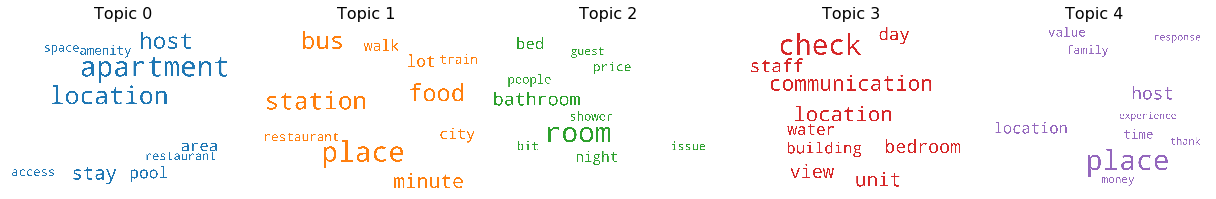

In [68]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model5.show_topics(formatted=False)

fig, axes = plt.subplots(1, 5, figsize=(17,17), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

#### Word Count and Importance of Topic Keywords per Topic

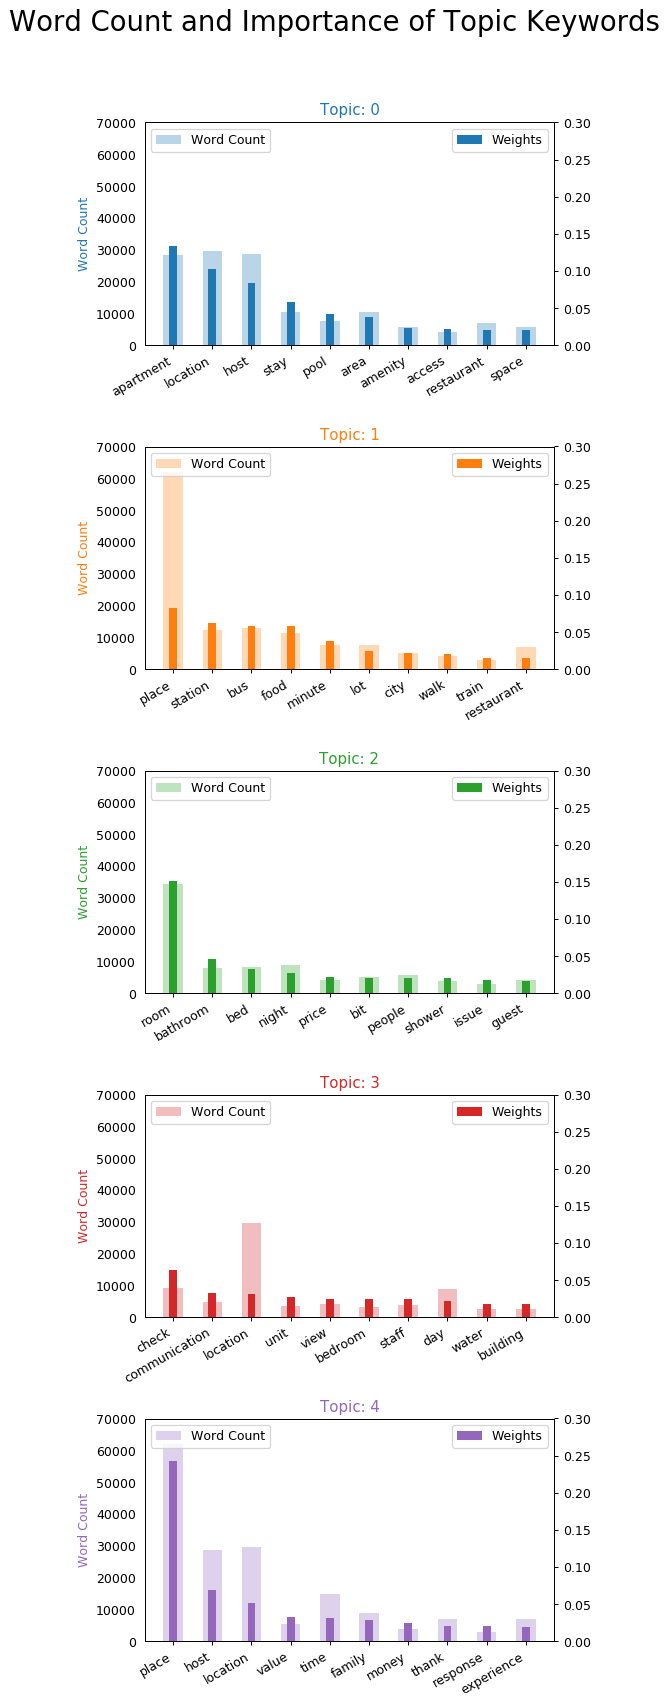

In [69]:
from collections import Counter

topics = lda_model5.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 1, figsize=(6,18), sharey=True, dpi=90)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.3); ax.set_ylim(0, 70000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=12)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

#### Print the Keyword in the 9 topics

In [70]:
pprint(lda_model5.print_topics())
doc_lda5 = lda_model5[corpus]

[(0,
  '0.133*"apartment" + 0.103*"location" + 0.084*"host" + 0.058*"stay" + '
  '0.041*"pool" + 0.038*"area" + 0.023*"amenity" + 0.022*"access" + '
  '0.021*"restaurant" + 0.021*"space"'),
 (1,
  '0.082*"place" + 0.062*"station" + 0.058*"bus" + 0.058*"food" + '
  '0.038*"minute" + 0.025*"lot" + 0.021*"city" + 0.021*"walk" + 0.015*"train" '
  '+ 0.015*"restaurant"'),
 (2,
  '0.151*"room" + 0.046*"bathroom" + 0.033*"bed" + 0.027*"night" + '
  '0.022*"price" + 0.020*"bit" + 0.020*"people" + 0.020*"shower" + '
  '0.018*"issue" + 0.017*"guest"'),
 (3,
  '0.064*"check" + 0.033*"communication" + 0.032*"location" + 0.027*"unit" + '
  '0.025*"view" + 0.024*"bedroom" + 0.024*"staff" + 0.022*"day" + '
  '0.018*"water" + 0.018*"building"'),
 (4,
  '0.242*"place" + 0.069*"host" + 0.051*"location" + 0.032*"value" + '
  '0.032*"time" + 0.028*"family" + 0.024*"money" + 0.021*"thank" + '
  '0.020*"response" + 0.019*"experience"')]


#### Computing the total number of documents attributed to each topic.

In [71]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model5, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model9.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

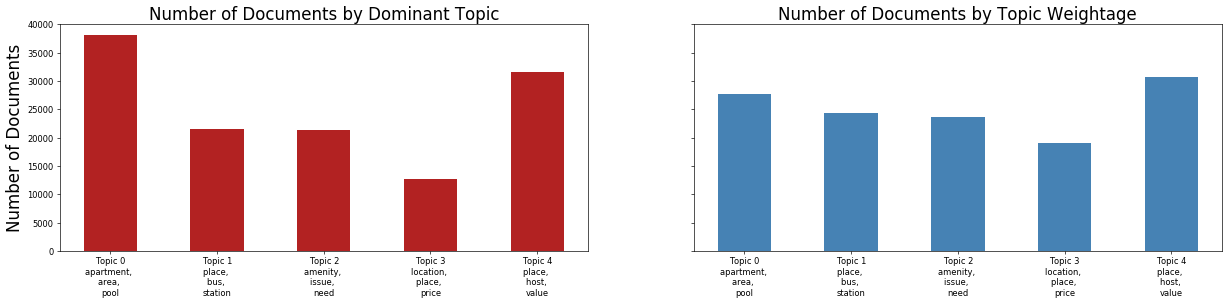

In [72]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25, 5), dpi=60, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=20))
ax1.set_ylabel('Number of Documents', fontsize = 20)
ax1.set_ylim(0, 40000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=20))



plt.show()

- Right: The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
- Left: The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

In [73]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model5[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 99501 samples in 0.058s...
[t-SNE] Computed neighbors for 99501 samples in 3.374s...
[t-SNE] Computed conditional probabilities for sample 1000 / 99501
[t-SNE] Computed conditional probabilities for sample 2000 / 99501
[t-SNE] Computed conditional probabilities for sample 3000 / 99501
[t-SNE] Computed conditional probabilities for sample 4000 / 99501
[t-SNE] Computed conditional probabilities for sample 5000 / 99501
[t-SNE] Computed conditional probabilities for sample 6000 / 99501
[t-SNE] Computed conditional probabilities for sample 7000 / 99501
[t-SNE] Computed conditional probabilities for sample 8000 / 99501
[t-SNE] Computed conditional probabilities for sample 9000 / 99501
[t-SNE] Computed conditional probabilities for sample 10000 / 99501
[t-SNE] Computed conditional probabilities for sample 11000 / 99501
[t-SNE] Computed conditional probabilities for sample 12000 / 99501
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

--------------------

# Case Study on Listing_ID = 2129215

In [74]:
case = reviews[reviews['listing_id'] == 2129215]

In [75]:
case.shape

(294, 4)

In [76]:
case.head(5)

listing_id       date reviewer_name  \
4513  2129215    2014-01-14  Filip          
4514  2129215    2014-01-29  Rik            
4515  2129215    2014-02-08  Willis         
4516  2129215    2014-02-16  Eliott         
4517  2129215    2014-02-24  Won Hyun       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          comments  
4513  shirley is a great host i was very satisfied about the accommodation and service she provides its everything very professional with a lot of home feeling the rooms are modern and very clean mrt station is in walk distance but the house is on very calm and quiet street internet was the quickest i have ever seen and i would definetely recommend shirley to all looking for budget room and high service                                                                                                                                                                                              
4514  this apartment comes highly recommended it is an immaculate apartment and shirley is a wonderful host lovely facilities clean and comfortable the apartment is a stones throw from the mrt station restaurants and shops it's a home away from home we would definitely stay here again and again                                                                                                                                                                                                                                                                                                             
4515  we were lucky to find shirley's abode during the chinese new year period as she provided us with such great service and nothing else we could ask for the room was clean and kitchen supplies was complete she even provided chinese new year goodies for us shirley anticipated our every need and was keen to help whenever possible (provided use of her kitchen for one night) the house was also located a short walk to kembangnan mrt which made transportation a breeze in summary i would like to thank shirley for providing us a clean and well stocked apartment during my short staynon-english  
4516  hi\r\n\r\nso basically kembangan is this new area in singapore clean neat with lots of good apartments and nice neighborhood shirley's place is 5 minutes walk from the mrt station (kembangan station)\r\n\r\nthe place is very clean and spacious she is very nice and lenient she allows us to stay longer from check out hours since i was sick well basically she's very warm and welcoming\r\n\r\nclean towels are available and they always clean up the rooms for us\r\n\r\nawesome trip                                                                                                              
4517  very good place\r\nthis is better than expected was really comfortable and cozy and clean\r\ni was kind of the master of the house \r\ni want to go next time

#### Cleaning Comments

In [77]:
# Remove punctuation
case['comments'] = case['comments'].map(lambda x: re.sub('[,.!?]', '', x))
# Convert the titles to lowercase
case['comments'] = case['comments'].map(lambda x: x.lower())
# Print out the first rows of papers
case['comments'].head(1)

/Users/shaunkse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/shaunkse/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


4513    shirley is a great host i was very satisfied about the accommodation and service she provides its everything very professional with a lot of home feeling the rooms are modern and very clean mrt station is in walk distance but the house is on very calm and quiet street internet was the quickest i have ever seen and i would definetely recommend shirley to all looking for budget room and high service
Name: comments, dtype: object

#### Tokenization, Stopwords, Lemmatization

In [78]:
# Tokenizing 
case_data = case.comments.values.tolist()
case_data_words = list(sent_to_words(case_data))

In [79]:
# Remove Stop Words
case_data_words_nostops = remove_stopwords(case_data_words)
# Form Bigrams
case_data_words_bigrams = make_bigrams(case_data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun
case_data_lemmatized = lemmatization(case_data_words_bigrams, allowed_postags=['NOUN'])

In [80]:
len(case_data_lemmatized)

294

In [81]:
print(case_data_words[2])

['we', 'were', 'lucky', 'to', 'find', 'shirley', 'abode', 'during', 'the', 'chinese', 'new', 'year', 'period', 'as', 'she', 'provided', 'us', 'with', 'such', 'great', 'service', 'and', 'nothing', 'else', 'we', 'could', 'ask', 'for', 'the', 'room', 'was', 'clean', 'and', 'kitchen', 'supplies', 'was', 'complete', 'she', 'even', 'provided', 'chinese', 'new', 'year', 'goodies', 'for', 'us', 'shirley', 'anticipated', 'our', 'every', 'need', 'and', 'was', 'keen', 'to', 'help', 'whenever', 'possible', 'provided', 'use', 'of', 'her', 'kitchen', 'for', 'one', 'night', 'the', 'house', 'was', 'also', 'located', 'short', 'walk', 'to', 'kembangnan', 'mrt', 'which', 'made', 'transportation', 'breeze', 'in', 'summary', 'would', 'like', 'to', 'thank', 'shirley', 'for', 'providing', 'us', 'clean', 'and', 'well', 'stocked', 'apartment', 'during', 'my', 'short', 'staynon', 'english']


In [82]:
case_data_lemmatized[2]

['year',
 'period',
 'service',
 'room',
 'kitchen',
 'supply',
 'need',
 'help',
 'kitchen',
 'night',
 'walk',
 'transportation',
 'breeze',
 'summary',
 'apartment']

Note: kitchen is repeated

In [83]:
# Create Dictionary
case_id2word = corpora.Dictionary(case_data_lemmatized)
# Create Corpus
case_texts = case_data_lemmatized
# Term Document Frequency
case_corpus = [case_id2word.doc2bow(text) for text in case_texts]

In [84]:
len(case_id2word)

636

In [85]:
case_id2word[22]

'transportation'

In [86]:
len(case_corpus)

294

In [87]:
case_corpus[2]

[(5, 1),
 (6, 1),
 (8, 1),
 (14, 1),
 (15, 1),
 (16, 2),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 1),
 (21, 1),
 (22, 1),
 (23, 1),
 (24, 1)]

Note: id2word 16 is kitchen 

In [88]:
lda_model5[case_corpus[2]]
# ([topic_percs], [wordid_topics], [wordid_phivalues])

([(0, 0.20868039),
  (1, 0.46010292),
  (2, 0.14007354),
  (3, 0.17801028),
  (4, 0.013132856)],
 [(5, [2]),
  (6, [1]),
  (8, [1]),
  (14, [0]),
  (15, [0]),
  (16, [1]),
  (17, [0, 2]),
  (18, [2, 3]),
  (19, [1, 3]),
  (20, [3]),
  (21, [1, 0]),
  (22, [3, 1, 0, 2]),
  (23, [3]),
  (24, [1])],
 [(5, [(2, 0.9999719)]),
  (6, [(1, 0.9997882)]),
  (8, [(1, 0.99999213)]),
  (14, [(0, 0.99931896)]),
  (15, [(0, 0.99996364)]),
  (16, [(1, 1.9997333)]),
  (17, [(0, 0.7234865), (2, 0.20349842)]),
  (18, [(2, 0.72250736), (3, 0.27694485)]),
  (19, [(1, 0.9518327), (3, 0.048109964)]),
  (20, [(3, 0.9994171)]),
  (21, [(0, 0.19880602), (1, 0.8011847)]),
  (22, [(0, 0.07026422), (1, 0.077355854), (2, 0.016130645), (3, 0.19528055)]),
  (23, [(3, 0.9999624)]),
  (24, [(1, 0.9998047)])])

Question: why LDA did not classify id2word 17 and 22 into any topic?

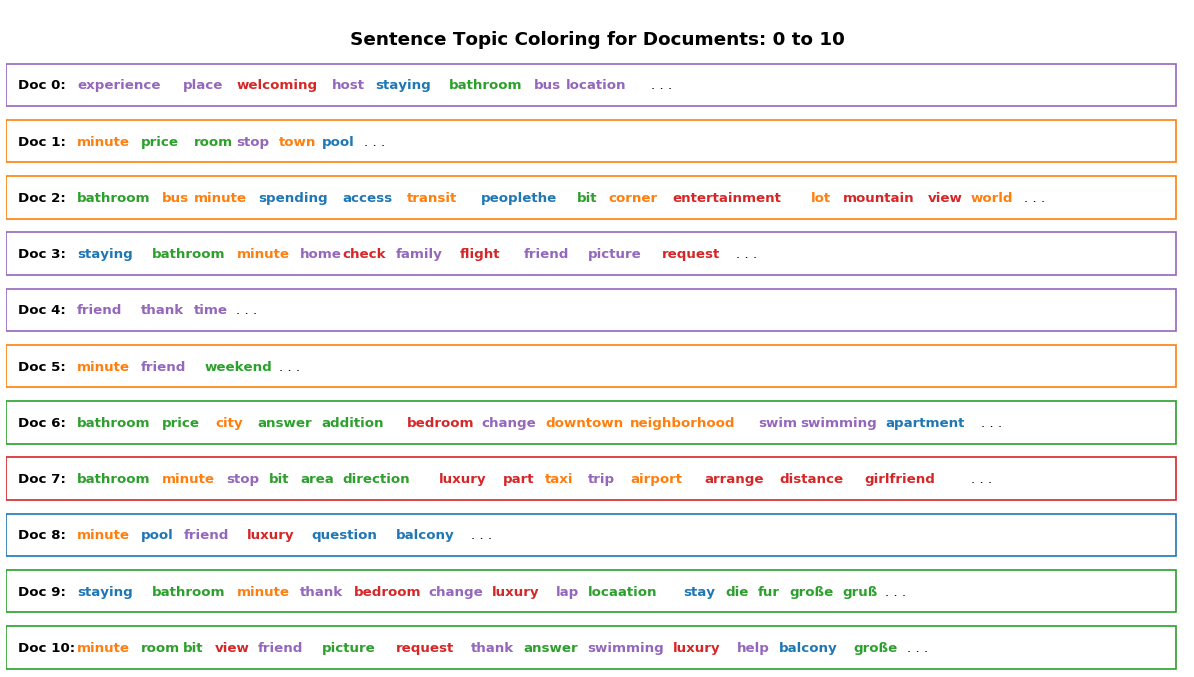

In [89]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model5, corpus=case_corpus, start = 0, end = 12):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=60)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
     
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
          
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics if len(topic) != 0]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [90]:
len(case_corpus)

294

In [91]:
lda_model5[case_corpus][0]

([(0, 0.16033733),
  (1, 0.019154368),
  (2, 0.20003964),
  (3, 0.12432528),
  (4, 0.49614337)],
 [(0, [4, 3]),
  (1, [4]),
  (2, [3]),
  (3, [4, 0]),
  (4, [0]),
  (5, [2]),
  (6, [4, 1]),
  (7, [4, 0, 3])],
 [(0, [(3, 0.09935992), (4, 0.9006271)]),
  (1, [(4, 0.99955124)]),
  (2, [(3, 0.9983804)]),
  (3, [(0, 0.24114299), (4, 0.75885403)]),
  (4, [(0, 0.9993543)]),
  (5, [(2, 1.999963)]),
  (6, [(1, 0.0100860465), (4, 1.9898778)]),
  (7, [(0, 0.32240358), (3, 0.06952091), (4, 0.6080724)])])

In [92]:
lda_model5[case_corpus[0]][0]

[(0, 0.16030952),
 (1, 0.01914589),
 (2, 0.20003964),
 (3, 0.124321945),
 (4, 0.496183)]

In [93]:
# Extracting only the topic weights/% from the ldamodel
comment_topic=[]
for i in range (len(case_corpus)):
    comment_topic.append(lda_model5[case_corpus[i]][0])

In [94]:
comment_topic

[[(0, 0.16030951),
  (1, 0.019145887),
  (2, 0.20003964),
  (3, 0.124321945),
  (4, 0.49618304)],
 [(0, 0.182072),
  (1, 0.36793068),
  (2, 0.27500558),
  (3, 0.025000742),
  (4, 0.14999098)],
 [(0, 0.20871127),
  (1, 0.46008638),
  (2, 0.14000192),
  (3, 0.17806771),
  (4, 0.0131327305)],
 [(0, 0.13235855),
  (1, 0.100005224),
  (2, 0.12478685),
  (3, 0.26668337),
  (4, 0.37616602)],
 [(0, 0.050419573),
  (1, 0.050000314),
  (2, 0.050082702),
  (3, 0.050241027),
  (4, 0.7992564)],
 [(0, 0.040002894),
  (1, 0.44003552),
  (2, 0.23995233),
  (3, 0.040002897),
  (4, 0.24000637)],
 [(0, 0.17829378),
  (1, 0.16020821),
  (2, 0.3006511),
  (3, 0.09231547),
  (4, 0.26853147)],
 [(0, 0.112119995),
  (1, 0.15839742),
  (2, 0.26274192),
  (3, 0.31036654),
  (4, 0.1563741)],
 [(0, 0.4571362),
  (1, 0.17145935),
  (2, 0.028659318),
  (3, 0.17129625),
  (4, 0.17144887)],
 [(0, 0.16492888),
  (1, 0.07972906),
  (2, 0.39570263),
  (3, 0.14784712),
  (4, 0.21179228)],
 [(0, 0.1219252),
  (1, 0.143178

In [95]:
topic_weight = [max(i, key = lambda x:x[1]) for i in comment_topic]

In [96]:
topic_weight

[(4, 0.49618304),
 (1, 0.36793068),
 (1, 0.46008638),
 (4, 0.37616602),
 (4, 0.7992564),
 (1, 0.44003552),
 (2, 0.3006511),
 (3, 0.31036654),
 (0, 0.4571362),
 (2, 0.39570263),
 (2, 0.44362482),
 (2, 0.3611371),
 (4, 0.7328481),
 (2, 0.3779093),
 (2, 0.564171),
 (4, 0.4280036),
 (2, 0.44973925),
 (4, 0.26769015),
 (2, 0.6494854),
 (3, 0.330186),
 (4, 0.25603935),
 (1, 0.27710843),
 (4, 0.53845346),
 (4, 0.40787125),
 (4, 0.89960027),
 (2, 0.30537102),
 (4, 0.43354356),
 (1, 0.45041394),
 (3, 0.3667691),
 (4, 0.53147227),
 (4, 0.30668148),
 (3, 0.29336885),
 (2, 0.38895783),
 (2, 0.3197952),
 (3, 0.32442385),
 (4, 0.5205021),
 (2, 0.28656203),
 (2, 0.3296199),
 (4, 0.79975474),
 (4, 0.41007966),
 (1, 0.3345084),
 (4, 0.33529183),
 (4, 0.45085475),
 (2, 0.29969743),
 (1, 0.3651956),
 (4, 0.28972447),
 (4, 0.5183998),
 (4, 0.43617806),
 (2, 0.33270124),
 (4, 0.40536377),
 (0, 0.2),
 (2, 0.5499089),
 (4, 0.65469205),
 (3, 0.5999828),
 (0, 0.2),
 (2, 0.39185223),
 (4, 0.32307673),
 (4, 0.46

In [97]:
len(topic_weight)

294

In [98]:
main_topic = [max(i, key=lambda x: x[1])[0] for i in comment_topic]

In [99]:
main_topic = pd.Series(main_topic)

In [100]:
main_topic.value_counts()

4    127
2    64 
0    40 
1    35 
3    28 
dtype: int64

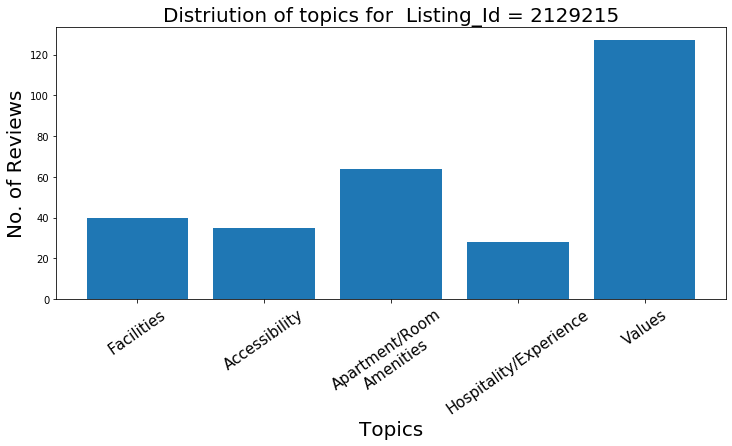

In [101]:
plt.figure(figsize=(12,5))
x = [0,1,2,3,4]
y = [40,35,64,28,127]

plt.bar(x, y)
plt.xlabel('Topics', fontsize=20)
plt.ylabel('No. of Reviews', fontsize=20)
plt.title('Distriution of topics for  Listing_Id = 2129215', fontsize=20)
plt.xticks(x, ('Facilities', 'Accessibility', 'Apartment/Room\nAmenities', 'Hospitality/Experience', 'Values'), rotation = 35, 
          fontsize=15)
plt.show()